# Verify the weight of V+ FFNN(can not show the power of quantum)

## Prepare environment and  define parameters 

In [1]:
is_colab = False
import sys
if is_colab:
    !pip install -q torch==1.8.1
    !pip install -q torchvision==0.4.0
    !pip install -q qiskit==0.14.0
    !pip install qfnn



import torch
import torchvision

import qiskit
from qiskit import  QuantumCircuit, ClassicalRegister
import numpy as np
import functools

In [2]:
sys.path.append('../')
from src.qfnn.qf_fb.q_output import fire_ibmq,analyze,add_measure
from src.qfnn.qf_circ.f_lyr_circ import F_LYR_Circ
from src.qfnn.qf_circ.v_lyr_circ import V_LYR_Circ
from src.qfnn.qf_net.utils import binarize
from src.qfnn.qf_fb.q_input import UMatrixCircuit
from src.qfnn.qf_fb.c_input import load_data,to_quantum_matrix

print = functools.partial(print, flush=True)



################ Zhirui on 12-30-2020 ################
# Parameters of settings
######################################################
interest_num = [3,6]
ori_img_size = 28
img_size = 4
num_workers = 0 # number of subprocesses to use for data loading
batch_size = 1# how many samples per batch to load
inference_batch_size = 1
isppd = False #is prepared data

################ Zhirui on 12-30-2020 ################
# path
######################################################
if is_colab:
    data_path = '/content/data' #mnist  path
    resume_path = '/content/libs/best_model/v_u.tar' #model path
else:
    data_path = '/home/hzr/Software/quantum/qc_mnist/pytorch/data' #mnist  path
    resume_path = '/home/hzr/Software/quantum/JQuantumFlow_tutorial/model/v16_v2/model_best.tar' #model path

## Load data

In [3]:
train_loader, test_loader = load_data(interest_num,data_path,isppd,img_size,batch_size,inference_batch_size,False)


for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    quantum_matrix = to_quantum_matrix(data)
    break

Batch Id: 0, Target: tensor([0])


## Inference

In [4]:
################ hzr on 12-30-2020 ################
# Get the parameters of the trained model
######################################################

# Model initialization
checkpoint = torch.load(resume_path, map_location='cpu')
# print(checkpoint['state_dict']['fc0.theta'])
# print(checkpoint['state_dict']['fc1.weight'])
theta1 = checkpoint['state_dict']['fc0.theta']
theta2 = checkpoint['state_dict']['fc1.theta']


In [5]:
################ hzr on 12-30-2020 ################
# Generate the circuit of u-Matrix
######################################################

#init circuit
circuit = QuantumCircuit()
#define your input and repeat number
u_mat = UMatrixCircuit(4,1)
#add input qubit to your circuit if needed
inputs = u_mat.add_input_qubits(circuit)
#add u-matrix to your circuit
u_mat.forward(circuit,inputs,quantum_matrix)

In [6]:
################ hzr on 12-30-2020 ################
# Generate the circuit of v-layer
######################################################

#define your input and repeat number
vqc = V_LYR_Circ(4,1)
#add v-layer to your circuit
vqc.forward(circuit,inputs,'v10',np.array(theta1,dtype=np.double))

vqc.forward(circuit,inputs,'v10',np.array(theta2,dtype=np.double))


/home/hzr/anaconda3/envs/qf/lib/python3.8/site-packages/torch/_tensor.py:645: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


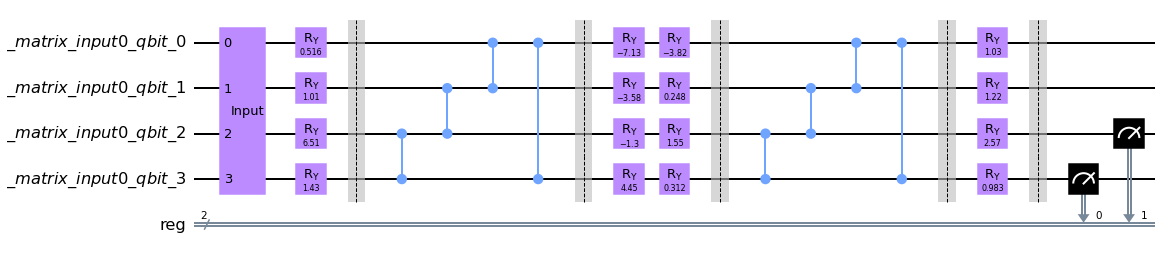

In [7]:



circuit.barrier()
#add measurement to your circuit if needed
add_measure(circuit,[inputs[0][3],inputs[0][2]],'reg')

#show your circuit
if is_colab:
    layout = 'text'
    fold = 300
else:
    layout = 'mpl'
    fold = 50

circuit.draw(layout,fold=fold)



### Non-Optimized Circuit v.s. Optimized Circuit

Let's test and compare!


In [8]:
################ Weiwen on 12-30-2020 ################
# Quantum simulation
######################################################


qc_shots=8192
opt_counts = fire_ibmq(circuit,qc_shots,True)
(opt_mycount,bits) = analyze(opt_counts)
opt_class_prob=[]
for b in range(bits):
    opt_class_prob.append(float(opt_mycount[b])/qc_shots)


print("Result of optimized QC:",opt_class_prob)
print("Prediction class: {}".format(opt_class_prob.index(max(opt_class_prob))))
print("Target class: {}".format(target[0]))
if opt_class_prob.index(max(opt_class_prob))==target[0]:
    print("Correct prediction")
else:
    print("Incorrect prediction")
print("="*30)

Result of optimized QC: [0.774169921875, 0.214599609375]
Prediction class: 0
Target class: 0
Correct prediction


In [9]:
from src.qfnn.qf_fb.c_qf_mixer import Net
from src.qfnn.qf_fb.c_input import ToQuantumData
neural_in_layers = 'v:16,v:2'
layers = []
for item1 in neural_in_layers.split(","):
    x= item1.split(":")
    layer =[]
    layer.append(x[0].strip())
    layer.append(int(x[1].strip()))
    layers.append(layer)

print("layers:",layers)
model = Net(img_size,layers,False,False)
model.load_state_dict(checkpoint["state_dict"])
# print(quantum_matrix)
to_quantum_data = ToQuantumData(img_size)
output_data = to_quantum_data(data)
output = model.forward(output_data,False)
print(output)

layers: [['v', 16], ['v', 2]]
tensor([[0.7755, 0.2140]], grad_fn=<CopyBackwards>)


/home/hzr/Software/quantum/JQuantumFlow_tutorial/tests/../src/qfnn/qf_net/v_lyr.py:312: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448216815/work/aten/src/ATen/native/Copy.cpp:240.)
  return x.t().float()
